# Presentation

In this project I am working with the Eropean soccer database to explore the attributes of the team as well as make a comparison between the teams in the 11 Europe countries by making some visualization. In addtion, applying machine learning to build a model to predict the outcome of a game.

## Data

The European soccer database is an ultimate Soccer database on Kaggle inlcuding more than 10,000 players and 25,000 matches in 11 European Countries with their lead championship from season 2008 to 2016. This data also include the attributes of the teams in these coutry from EA Sports' FIFA. 
This dataset is a sqlite file include 7 tables:
* Country: Id and name of country
* League:Id, country and name of league
* Match: Id of two team and the events of the game such as goal, corner, cross, fouls, etc
* Player: Player's information
* Player_Attributes: Attributes of player
* Team: team's information
* Team_attribute: Attributes of each team

## Import and Tidy

### import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from seaborn import load_dataset
from sqlalchemy import create_engine
from pandas.io import sql
from sqlalchemy import inspect
import pyarrow.parquet as pq
import pyarrow as pa
import altair as alt
import networkx as nx
import plotly
plotly.tools.set_credentials_file(username='baocon1320', api_key='31stxvhpyPGedjTHps0u')
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
sns.set()
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from IPython.display import Image

### Data

* From the sqlite file, import only table and columns we need (match, team, team_atribute, country)


In [2]:
sc = create_engine('sqlite:////data/bnguy123/datasets/hugomathien/soccer/database.sqlite')
team = sql.read_sql_query("""SELECT team_api_id, team_short_name FROM Team""", sc)
team_att = sql.read_sql_query("""SELECT team_api_id, date, buildUpPlaySpeed, buildUpPlayDribbling,
buildUpPlayPassing, chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting, 
defencePressure, defenceAggression, defenceTeamWidth FROM Team_Attributes""", sc)
country = sql.read_sql_table('Country',sc)
match = sql.read_sql_query("""SELECT match_api_id, country_id, season, home_team_api_id,
away_team_api_id, home_team_goal, away_team_goal FROM Match""", sc)

In [3]:
match.head()

,match_api_id,country_id,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,492473,1,2008/2009,9987,9993,1,1
1,492474,1,2008/2009,10000,9994,0,0
2,492475,1,2008/2009,9984,8635,0,3
3,492476,1,2008/2009,9991,9998,5,0
4,492477,1,2008/2009,7947,9985,1,3


In [4]:
team_att.head()

,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,9930,2010-02-22 00:00:00,60,NaN,50,60,65,55,50,55,45
1,9930,2014-09-19 00:00:00,52,48.0,56,54,63,64,47,44,54
2,9930,2015-09-10 00:00:00,47,41.0,54,54,63,64,47,44,54
3,8485,2010-02-22 00:00:00,70,NaN,70,70,70,70,60,70,70
4,8485,2011-02-22 00:00:00,47,NaN,52,53,48,52,47,47,52


* Focus on the table team_attribute and match
    * Team_attribute dataframe:
        * Get only the newest attributes ( from date 2015-09-10)
        * Include only the attribute and team Id
        * Add the country name column to the dataframe by merge with country dataframe
        * Check Null value
        * Change the column names
    * match dataframe:
        * Add the column result (home team win, loose or tie)
        * Add the home team name and away team name (Merge with team dataframe)
        * Check Null value
        * Change the column names
* Write to parquet file

In [5]:
team_table = pq.read_table('/data/bnguy123/team_table.parquet')
team_att = team_table.to_pandas()
match_table = pq.read_table('/data/bnguy123/match_table.parquet')
match = match_table.to_pandas()

In [6]:
match.head()

,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team,away_team,country_name,result
match_api_id,,,,,,,,,
492473,2008/2009,9987,9993,1,1,GEN,BAC,Belgium,tie
665353,2009/2010,9987,9993,1,1,GEN,BAC,Belgium,tie
838476,2010/2011,9987,9993,2,1,GEN,BAC,Belgium,win
1032694,2011/2012,9987,9993,3,1,GEN,BAC,Belgium,win
1224064,2012/2013,9987,9993,3,0,GEN,BAC,Belgium,win


In [7]:
team_att.head()

,date_update,speed,dribbling,passing,crossing,shooting,defence,country_name
team_id,,,,,,,,
1601,2015-09-10 00:00:00,47,48.0,49,65,50,45,Poland
1957,2015-09-10 00:00:00,66,54.0,45,33,66,54,Poland
2182,2015-09-10 00:00:00,57,50.0,49,70,67,51,Poland
2186,2015-09-10 00:00:00,37,50.0,52,66,33,52,Poland
4087,2015-09-10 00:00:00,58,35.0,54,61,51,46,France


## Exploratory Data Analysis

### Three questions:

1. Which team is the best soccer team in each of those 11 country in Europe?
    * Using Networkx to make graph
        * each team is a node
        * node's size proportion with number of win game 
        * edge witdh is proportion with number of game between 2 team
        * Different country with different color



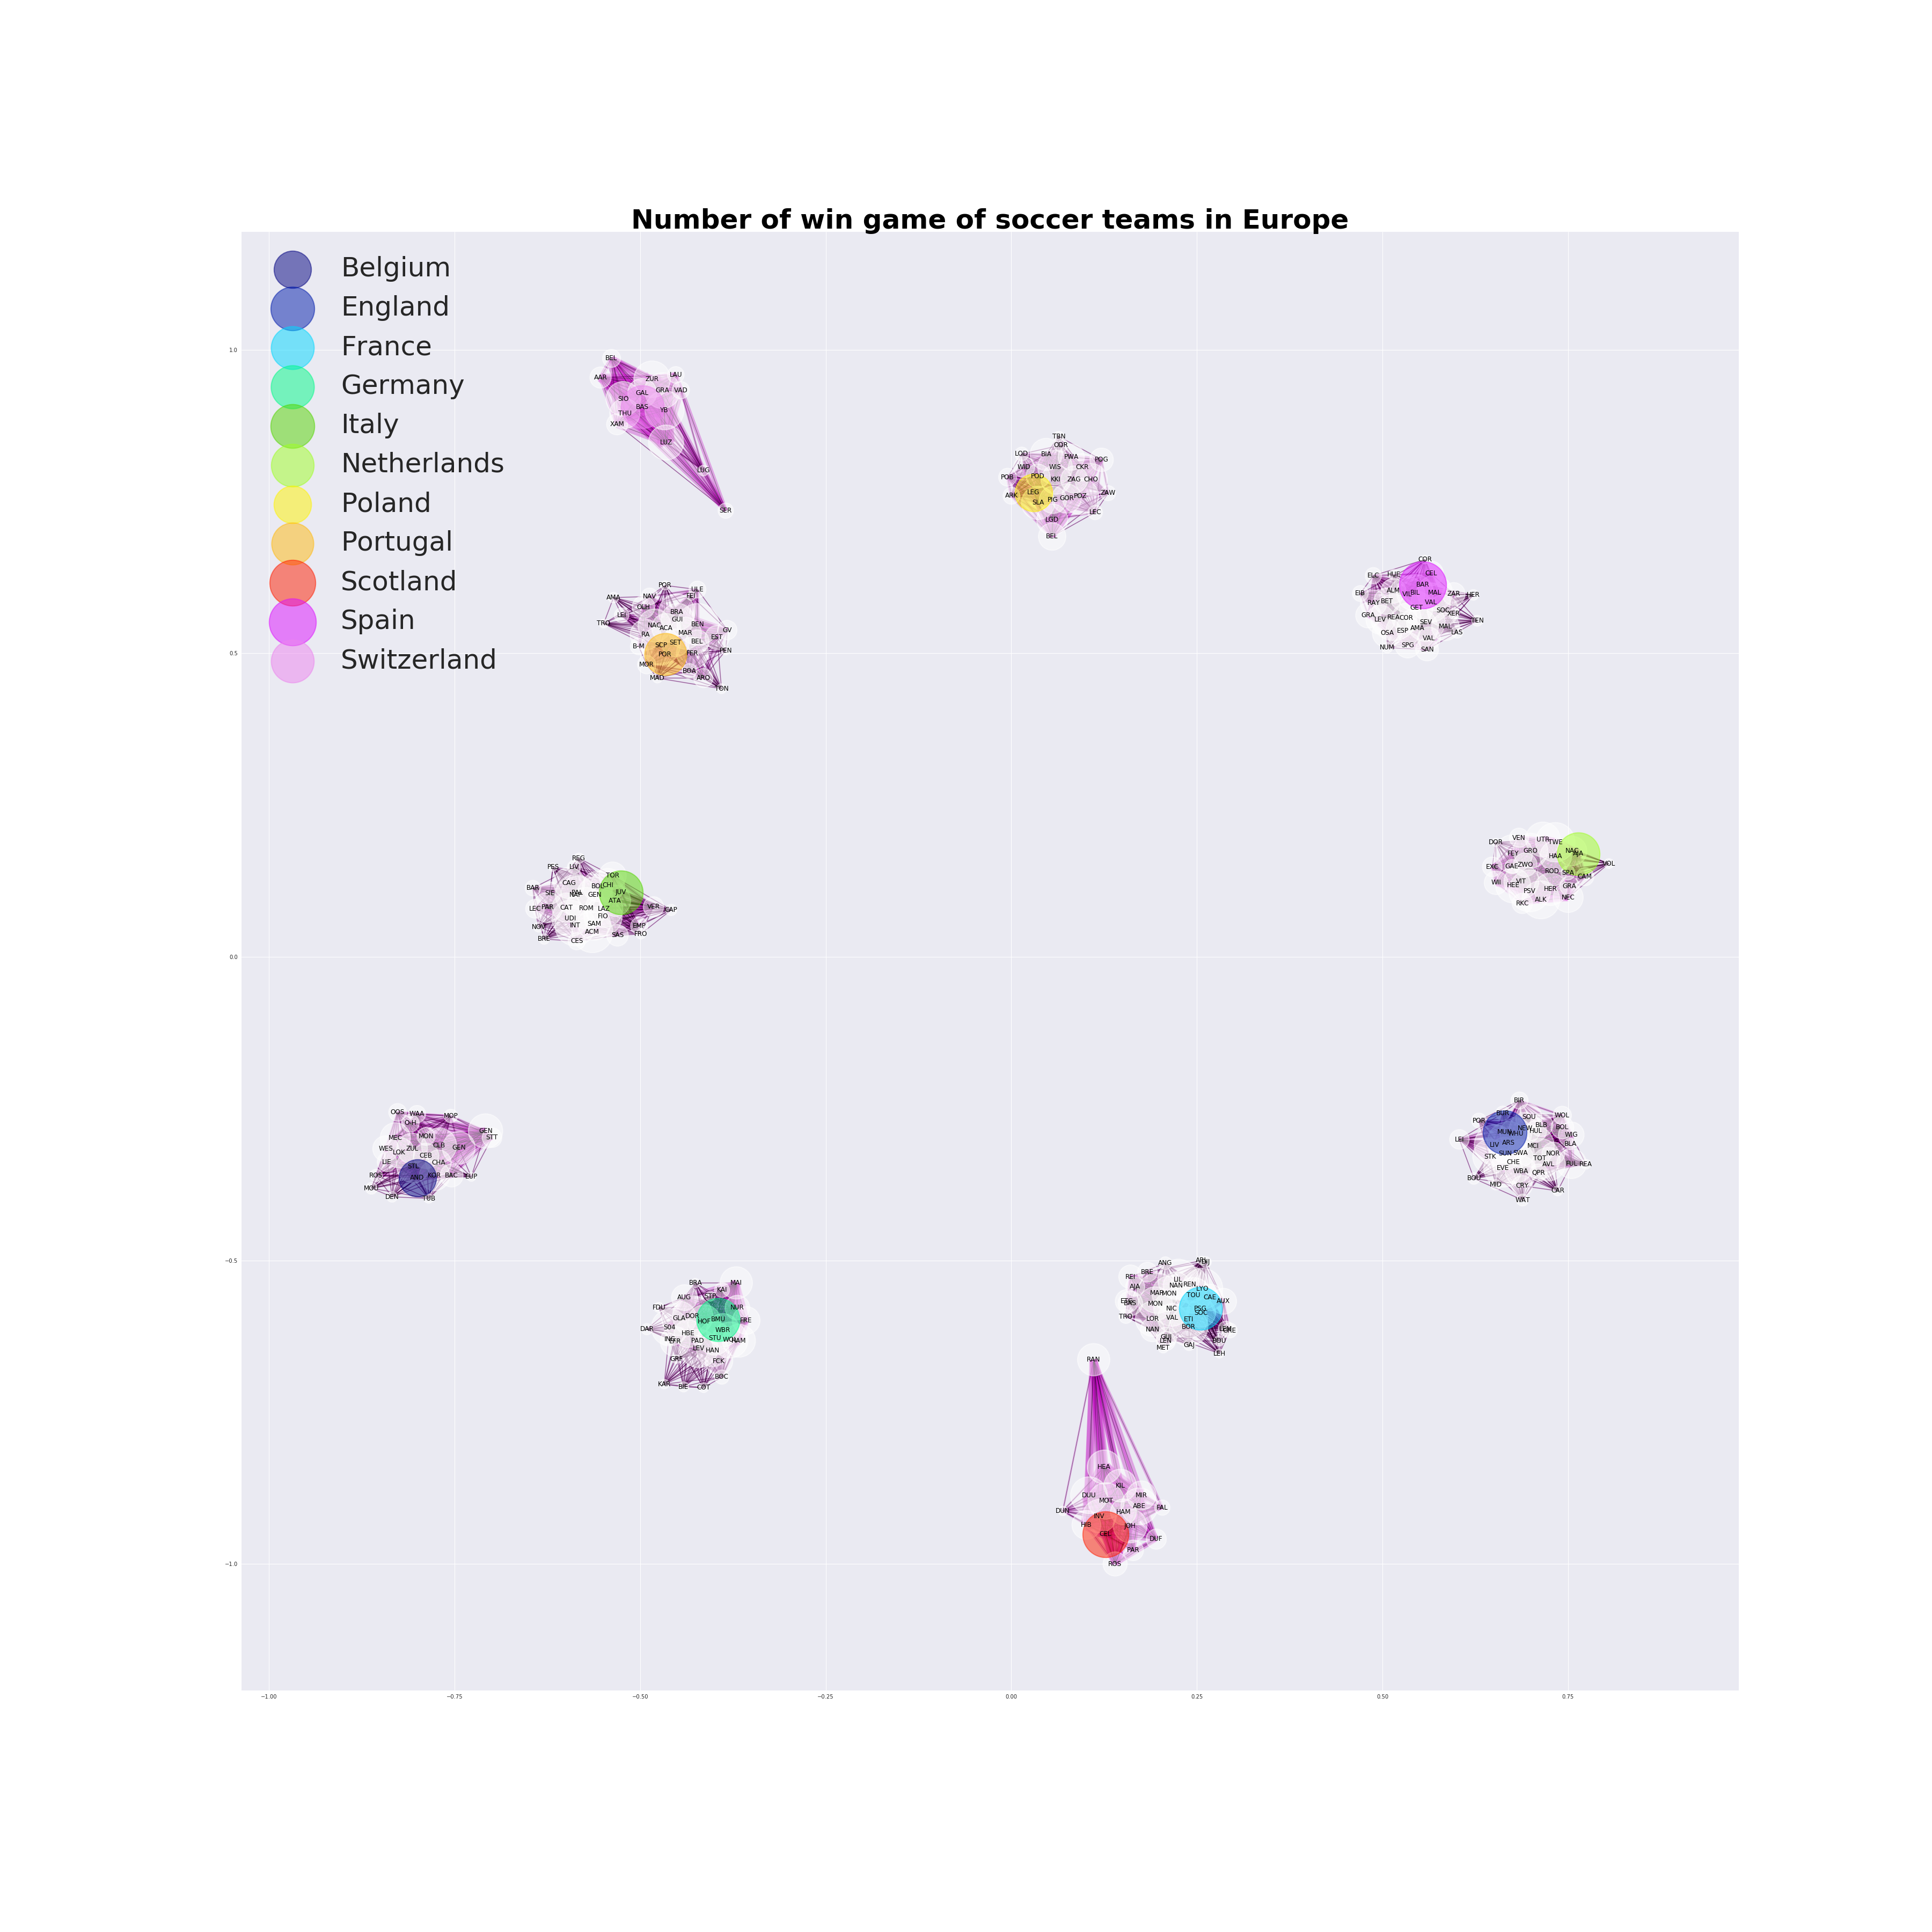

In [8]:
Image(filename='/data/bnguy123/win_rate.png')

Question 2: Which country has the best average attributes and in which specific attibute that they are leading?
    * Group the data by country and melting the dataset to set the attribute columns to variables to make the bar chart including different attributes
   


In [9]:
team_att['total_att'] = team_att.loc[:, 'speed':'defence'].sum(1)
groups = team_att.groupby('country_name')['total_att', 'speed', 'passing', 
                                          'crossing','shooting','defence' ].mean().reset_index()
att = pd.melt(groups, id_vars=['country_name','total_att'], value_vars=['speed', 'passing',
      'crossing','shooting', 'defence'],var_name='attribute', value_name='score')
alt.Chart(att).mark_bar().encode(
    alt.Y('country_name', sort=alt.SortField(field='total_att', op='average', order='descending')),
    alt.X('sum(score):Q'),
    alt.Color('attribute')
)

<VegaLite 2 object>

 * Make a radar chart by using plotly to see which specific attribute Italy is leading
        * Speed
        * Shooting

In [10]:
plot_data = groups.drop('total_att', axis = 1)
plot_data.set_index('country_name', inplace=True)
radar_data = list()
for i in range(11):
    radar_data.append(go.Scatterpolar(
          r = plot_data.values[i],
          theta = plot_data.columns.values,
          fill = 'toself',
          name = plot_data.index[i]))


layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = False,
      range = [0, 65]
    )
  ),
  showlegend = True
)

fig = go.Figure(data=radar_data, layout=layout)
py.iplot(fig)


Question 3. Is there any relation between those attributes?
    * Make pair plot by using seaborn for each pair of the attributes
        * There is a correlation between passing - crossing and passing - speed
    * Calculating the correlation score
        * passing - crossing: 0.317257
        * passing - speed: 0.326441

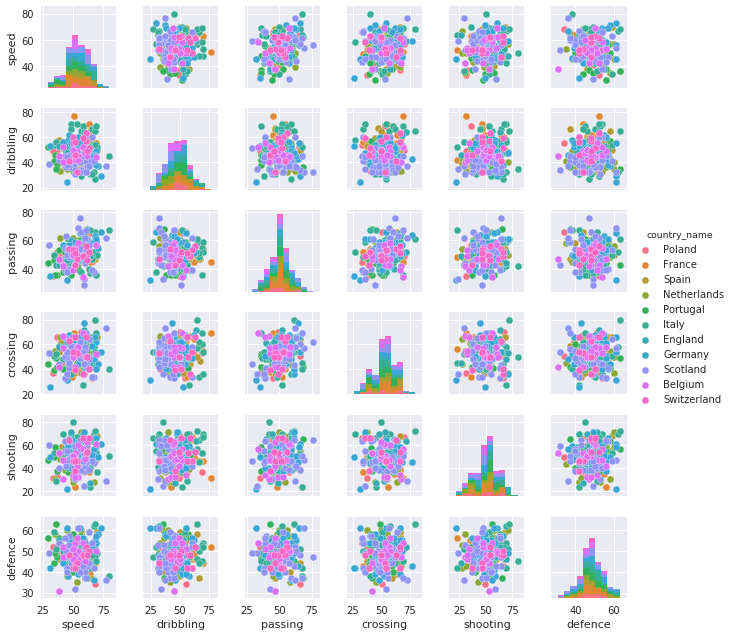

In [11]:
team_test = team_att.drop(['date_update', 'total_att'], axis = 1)
sns.pairplot(team_test, hue='country_name', size=1.5);

In [12]:
team_test.loc[:,['crossing', 'passing','speed']].corr()

,crossing,passing,speed
crossing,1.000000,0.317257,0.109861
passing,0.317257,1.000000,0.326441
speed,0.109861,0.326441,1.000000


This shows there is a good amount of correlation between pair passing-crossing and passing-speed

## Modeling

* Predict the outcome of a soccer game from the attributes of each team
    * Using Gaussian Naive Bayes model to training the data: which gave the better result compare to 
    KNeighborsClassifier and Random Forests
        * Attribute of home team and away team are data we use to predict 
        * Outcome of the game is what we want to predict (home team win, loose or tie) on from season 2015
   
    
    

In [13]:
match = match[match['season'] == '2015/2016']
temp = pd.merge(match, team_att, left_on='home_team_api_id', right_index=True)
predict_data = pd.merge(temp, team_att, left_on='away_team_api_id', right_index=True)
predict_data = predict_data.drop(['season','home_team_api_id','away_team_api_id', 
                                  'home_team_goal','away_team_goal','country_name_x',
                                  'date_update_x','date_update_y','country_name',
                                  'country_name_y','home_team', 'away_team' ], axis = 1)


In [14]:
predict_data.head()

,result,speed_x,dribbling_x,passing_x,crossing_x,shooting_x,defence_x,total_att_x,speed_y,dribbling_y,passing_y,crossing_y,shooting_y,defence_y,total_att_y
match_api_id,,,,,,,,,,,,,,,
1980066,win,58,52.0,34,69,56,54,323.0,60,47.0,50,50,48,45,300.0
1980019,loose,54,42.0,49,52,32,46,275.0,60,47.0,50,50,48,45,300.0
1979938,loose,50,55.0,39,66,34,51,295.0,60,47.0,50,50,48,45,300.0
1979890,loose,52,42.0,43,53,50,48,288.0,60,47.0,50,50,48,45,300.0
1979983,win,52,46.0,53,55,32,48,286.0,60,47.0,50,50,48,45,300.0


Split your data into a training and test set with 70% of the data used for training and a random_state=0. And apply the model, calculate the accuracy score

In [15]:
X_game = predict_data.drop('result', axis=1)
y_game = predict_data['result']
X_game_train, X_game_test, y_game_train, y_game_test = train_test_split(X_game, y_game, 
                                        random_state=0, test_size = 0.3)
model = GaussianNB()                       
model.fit(X_game_train, y_game_train)                  
y_model = model.predict(X_game_test) 

In [16]:
accuracy_score(y_game_test, y_model)

0.47570621468926555

I can also use cross_val_score to perform k-fold cross validation (k=10) with this model to get the more accuracy result

In [17]:
result = cross_val_score(model, X_game, y_game, cv=10)
result.mean()

0.4556557733620184

Use confusion matrix to learn more about the performance of this model 

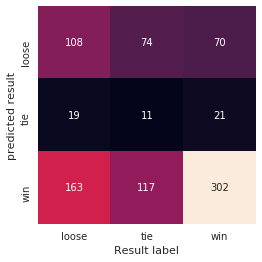

In [18]:
mat = confusion_matrix(y_game_test, y_model)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['loose','tie','win'], yticklabels=['loose','tie','win'])
plt.xlabel('Result label')
plt.ylabel('predicted result');

From the confusion matrix we can easily see that this model is very successful in predict the home team is winning, but confusing in predict the home team is loose and especially which game is tie. It is reasonable since in the real life is is very difficult to predict if a game is tie

## Conclusion

We all know that to predict a outcome of a game is never been easy because beside those attributes of the two teams, there are many real time factor that can affect the outcome of a game such as the changing of roster if there is any player was injured or the form of that team during that time. Therefore, to make a better decision, we can look at the probaility of each outcome by predict_proba method and combine with the real time factor to give the final decision

In [19]:
yprob = model.predict_proba(X_game_test)
yprob[-1:].round(2)

array([[0.32, 0.38, 0.31]])